## Portfolio Part 2

The goal of the second Portfolio task is to train linear regression models to predict users' ratings towards movies. This involves a standard Data Science workflow: exploring data, building models, making predictions, and evaluating results. In this task, we will explore the impacts of feature selections and different sizes of training/testing data on the model performance. We will continue using the movielens dataset provided in Portfolio task 1. 

### Import Cleaned MovieLens Dataset
Save the cleaned data (i.e., after removing missing values and outliers) in the Portfolio task 1 as a csv file named 'movielens_data_clean.csv'. You may need to use the Pandas method, i.e., `to_csv`, for doing this. After that, please import the csv file (i.e., 'movielens_data_clean') and print out its total length.

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

df = pd.read_csv('files/movielens_data_clean.csv')
len(df)

96854

### Explore the Dataset

* Use the methods, i.e., `head()` and `info()`, to have a rough picture about the data, e.g., how many columns, and the data types of each column. 
* As our goal is to predict ratings given other columns, please get the correlations between age/gender/genre/occupation and rating by using the `corr()` method.
* To get the correlations between different features, you may need to first convert the categorical features (i.e., gender, genre and occupation) into numerial values. For doing this, you may need to import `OrdinalEncoder` from `sklearn.preprocessing` (refer to the useful exmaples [here](https://pbpython.com/categorical-encoding.html))
* Please provide ___necessary explanations/analysis___ on the correlations, and figure out which are the ___most___ and ___least___ corrleated features regarding rating. Try to ___discuss___ how the correlation will affect the final prediction results, if we use these features to train a regression model for rating prediction. In what follows, we will conduct experiments to verify your hypothesis.

In [210]:
df.head()

,userId,age,gender,occupation,movieId,rating,genre,timestamp
0,196,49.0,M,writer,242,3.0,Comedy,881250949
1,22,25.0,M,writer,377,1.0,Children,878887116
2,244,28.0,M,technician,51,2.0,Romance,880606923
3,298,44.0,M,executive,474,4.0,War,884182806
4,253,26.0,F,librarian,465,5.0,Adventure,891628467


In [211]:
# Data types for the features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96854 entries, 0 to 96853
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   userId      96854 non-null  int64  
 1   age         96854 non-null  float64
 2   gender      96854 non-null  object 
 3   occupation  96854 non-null  object 
 4   movieId     96854 non-null  int64  
 5   rating      96854 non-null  float64
 6   genre       96854 non-null  object 
 7   timestamp   96854 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 5.9+ MB


In [212]:
# Features which are objects
obj_df = df.select_dtypes(include=['object']).copy()
obj_df.head()

,gender,occupation,genre
0,M,writer,Comedy
1,M,writer,Children
2,M,technician,Romance
3,M,executive,War
4,F,librarian,Adventure


In [213]:
# Using Ordinal Encoder to change the feature values from object to float64
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
obj_df["gender_code"] = ord_enc.fit_transform(obj_df[["gender"]])
obj_df["occupation_code"] = ord_enc.fit_transform(obj_df[["occupation"]])
obj_df["genre_code"] = ord_enc.fit_transform(obj_df[["genre"]])
obj_df = obj_df[['gender_code', 'occupation_code', 'genre_code']]
obj_df

,gender_code,occupation_code,genre_code
0,1.0,19.0,4.0
1,1.0,19.0,3.0
2,1.0,18.0,13.0
3,1.0,6.0,16.0
4,0.0,10.0,1.0
...,...,...,...
96849,1.0,17.0,4.0
96850,0.0,0.0,14.0
96851,1.0,17.0,15.0
96852,1.0,3.0,4.0


In [214]:
obj_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96854 entries, 0 to 96853
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender_code      96854 non-null  float64
 1   occupation_code  96854 non-null  float64
 2   genre_code       96854 non-null  float64
dtypes: float64(3)
memory usage: 2.2 MB


In [215]:
# Using join() to add new float64 features to the original dataset to observe the correalation with rating
df = df.join(obj_df)
df

,userId,age,gender,occupation,movieId,rating,genre,timestamp,gender_code,occupation_code,genre_code
0,196,49.0,M,writer,242,3.0,Comedy,881250949,1.0,19.0,4.0
1,22,25.0,M,writer,377,1.0,Children,878887116,1.0,19.0,3.0
2,244,28.0,M,technician,51,2.0,Romance,880606923,1.0,18.0,13.0
3,298,44.0,M,executive,474,4.0,War,884182806,1.0,6.0,16.0
4,253,26.0,F,librarian,465,5.0,Adventure,891628467,0.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
96849,880,13.0,M,student,476,3.0,Comedy,880175444,1.0,17.0,4.0
96850,716,36.0,F,administrator,204,5.0,Sci-Fi,879795543,0.0,0.0,14.0
96851,276,21.0,M,student,1090,1.0,Thriller,874795795,1.0,17.0,15.0
96852,13,47.0,M,educator,225,2.0,Comedy,882399156,1.0,3.0,4.0


In [216]:
# Correalation matrix for relevant the features of the dataframe
df[['rating', 'gender_code', 'occupation_code', 'genre_code', 'age']].corr()

,rating,gender_code,occupation_code,genre_code,age
rating,1.000000,-0.007239,-0.033717,0.045250,0.051724
gender_code,-0.007239,1.000000,0.012117,-0.000509,0.037126
occupation_code,-0.033717,0.012117,1.000000,-0.011443,-0.370879
genre_code,0.045250,-0.000509,-0.011443,1.000000,0.027286
age,0.051724,0.037126,-0.370879,0.027286,1.000000


<AxesSubplot:>

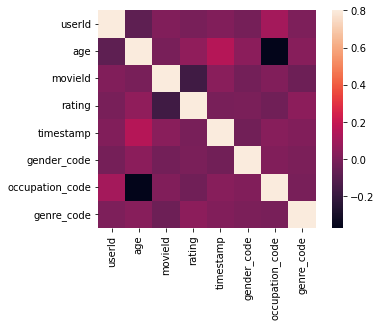

In [217]:
# Draw the heatmap using seaborn
corrmat = df.corr()
sns.heatmap(corrmat, vmax = .8, square = True)

There is little to no correalation between rating and gender/occupation/genre/age. The feature with the most correalation with rating is age and the feature with the least correalation is gender. The low correaltion indicates that the features would be inaccurate in predicting rating. 

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set. 
* To further investigate whether the size of the training/testing data affects the model performance, please random split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data. 
* Print the shape of training and testing sets in the two cases. 

In [218]:
# For Case 1 split the data into training and testing sets with the training data containg 10% of the data set 
trainC1, testC1 = train_test_split(df, test_size=0.9, random_state=50)
print('Shape of training data for case 1', trainC1.shape)
print('Shape of testing data for case 1', testC1.shape)

Shape of training data for case 1 (9685, 11)
Shape of testing data for case 1 (87169, 11)


In [219]:
# For Case 2 split the data into training and testing sets with the training data containg 90% of the data set
trainC2, testC2 = train_test_split(df, test_size=0.1, random_state=50)
print('Shape of training data for case 2',trainC2.shape)
print('Shape of testing data for case 2',testC2.shape)

Shape of training data for case 2 (87168, 11)
Shape of testing data for case 2 (9686, 11)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results. 
* To investigate whether feature selection affects the model performance, please select two most correlated features and two least correlated features regarding rating, respectively. 
* Train four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

Most correalated features: Age and Genre\
Least correalated features: Occupation and Gender

In [220]:
# Train model with Case 1 with 2 most correalated features
reg = linear_model.LinearRegression()
Xtrain_C1_highcorr = trainC1[['genre_code', 'age']]
Ytrain_C1 = trainC1['rating']
Xtest_C1_highcorr = testC1[['genre_code', 'age']]
Ytest_C1 = testC1['rating']

regc1high = reg.fit(Xtrain_C1_highcorr, Ytrain_C1)
print("y = x *", regc1high.coef_, "+", regc1high.intercept_)

y = x * [0.01259623 0.00614155] + 3.2465306849421633


In [221]:
# Train model with Case 1 with 2 least correalated features
reg = linear_model.LinearRegression()
Xtrain_C1_lowcorr = trainC1[['occupation_code', 'gender_code']]
Ytrain_C1 = trainC1['rating']
Xtest_C1_lowcorr = testC1[['occupation_code', 'gender_code']]
Ytest_C1 = testC1['rating']

regc1low = reg.fit(Xtrain_C1_lowcorr, Ytrain_C1)
print("y = x *", regc1low.coef_, "+", regc1low.intercept_)

y = x * [-0.00633822 -0.01905025] + 3.6237900838599635


In [222]:
# Train model with Case 2 with 2 most correalated features
reg = linear_model.LinearRegression()
Xtrain_C2_highcorr = trainC2[['genre_code', 'age']]
Ytrain_C2 = trainC2['rating']
Xtest_C2_highcorr = testC2[['genre_code', 'age']]
Ytest_C2 = testC2['rating']

regc2high = reg.fit(Xtrain_C2_highcorr, Ytrain_C2)
print("y = x *", regc2high.coef_, "+", regc2high.intercept_)

y = x * [0.01000462 0.0049357 ] + 3.3087897466459144


In [223]:
# Train model with Case 2 with 2 least correalated features
reg = linear_model.LinearRegression()
Xtrain_C2_lowcorr = trainC2[['occupation_code', 'gender_code']]
Ytrain_C2 = trainC2['rating']
Xtest_C2_lowcorr = testC2[['occupation_code', 'gender_code']]
Ytest_C2 = testC2['rating']

regc2low = reg.fit(Xtrain_C2_lowcorr, Ytrain_C2)
print("y = x *", regc2low.coef_, "+", regc2low.intercept_)

y = x * [-0.00607893 -0.0103432 ] + 3.61838644475806


### Evaluate Models
* Evaluate the performance of the four models with two metrics, including MSE and Root MSE
* Print the results of the four models regarding the two metrics

In [224]:
# Evaluate model with Case 1 with 2 most correalated features
predc1high = regc1high.predict(Xtest_C1_highcorr)
mse_c1_high = mean_squared_error(Ytest_C1, predc1high)
r2_c1_high = r2_score(Ytest_C1, predc1high)
print('Test Set Performance:')
print("MSE:", mse_c1_high)
print("Root MSE:", np.sqrt(mse_c1_high))

Test Set Performance:
MSE: 1.2397423834339478
Root MSE: 1.1134371933045653


In [225]:
# Evaluate model with Case 1 with 2 least correalated features
predc1low = regc1low.predict(Xtest_C1_lowcorr)
mse_c1_low = mean_squared_error(Ytest_C1, predc1low)
r2_c1_low = r2_score(Ytest_C1, predc1low)
print('Test Set Performance:')
print("MSE:", mse_c1_low)
print("Root MSE:", np.sqrt(mse_c1_low))

Test Set Performance:
MSE: 1.2432263013783258
Root MSE: 1.1150005835775718


In [226]:
# Evaluate model with Case 2 with 2 most correalated features
predc2high = regc2high.predict(Xtest_C2_highcorr)
mse_c2_high = mean_squared_error(Ytest_C2, predc2high)
r2_c2_high = r2_score(Ytest_C2, predc2high)
print('Test Set Performance:')
print("MSE:", mse_c2_high)
print("Root MSE:", np.sqrt(mse_c2_high))

Test Set Performance:
MSE: 1.2522434816657781
Root MSE: 1.119036854471638


In [227]:
# Evaluate model with Case 2 with 2 least correalated features
predc2low = regc2low.predict(Xtest_C2_lowcorr)                   
mse_c2_low = mean_squared_error(Ytest_C2, predc2low)
r2_c2_low = r2_score(Ytest_C2, predc2low)
print('Test Set Performance:')
print("MSE:", mse_c2_low)
print("Root MSE:", np.sqrt(mse_c2_low))

Test Set Performance:
MSE: 1.2558781129195087
Root MSE: 1.1206596775647408


### Visualize, Compare and Analyze the Results
* Visulize the results, and perform ___insightful analysis___ on the obtained results. For better visualization, you may need to carefully set the scale for the y-axis.
* Normally, the model trained with most correlated features and more training data will get better results. Do you obtain the similar observations? If not, please ___explain the possible reasons___.

Comparasin of the accuaracy of the different models.

In [228]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [229]:
from tabulate import tabulate

In [230]:
# Create table to compare MSE and RMSE values for each case
data = [["Case 1 With High Correalation", mse_c1_high, np.sqrt(mse_c1_high)], 
        ["Case 1 With Low Correalation", mse_c1_low, np.sqrt(mse_c1_low)], 
        ["Case 2 With High Correalation", mse_c2_high, np.sqrt(mse_c2_high)], 
        ["Case 2 With Low Correalation", mse_c2_low, np.sqrt(mse_c2_low)]]
col_names = ["Case", "MSE", "RMSE"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═══════════════════════════════╤═════════╤═════════╕
│ Case                          │     MSE │    RMSE │
╞═══════════════════════════════╪═════════╪═════════╡
│ Case 1 With High Correalation │ 1.23974 │ 1.11344 │
├───────────────────────────────┼─────────┼─────────┤
│ Case 1 With Low Correalation  │ 1.24323 │ 1.115   │
├───────────────────────────────┼─────────┼─────────┤
│ Case 2 With High Correalation │ 1.25224 │ 1.11904 │
├───────────────────────────────┼─────────┼─────────┤
│ Case 2 With Low Correalation  │ 1.25588 │ 1.12066 │
╘═══════════════════════════════╧═════════╧═════════╛


(1.0, 1.5)

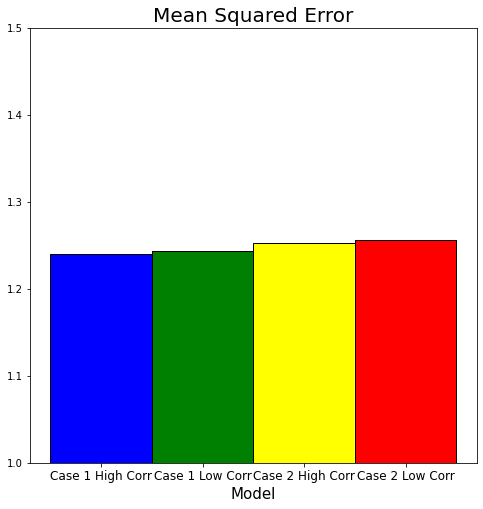

In [231]:
# Use a bar chart to visualize the MSE values for each model
y = [mse_c1_high, mse_c1_low, mse_c2_high, mse_c2_low]
x = ['Case 1 High Corr', 'Case 1 Low Corr', 'Case 2 High Corr', 'Case 2 Low Corr']
plt.figure(figsize=(8, 8))
plt.bar(x, y, width=1, color=['blue', 'green', 'yellow', 'red'],  edgecolor='black')
plt.xlabel("Model", size = 15)
plt.xticks(fontsize=12)
plt.title("Mean Squared Error", size = 20)
plt.ylim(1, 1.5)

(1.0, 1.5)

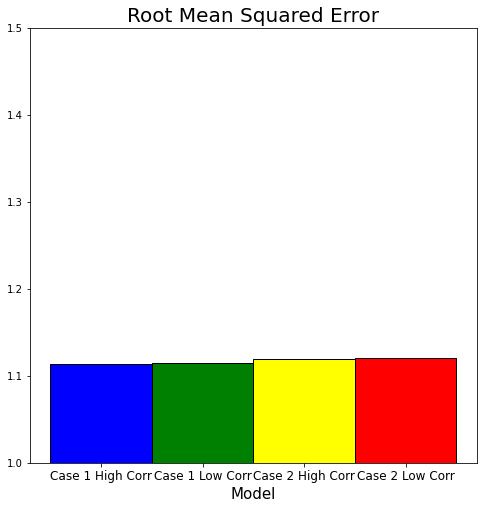

In [232]:
# Use a bar chart to visualize the RMSE values for each model
y = [np.sqrt(mse_c1_high), np.sqrt(mse_c1_low), np.sqrt(mse_c2_high), np.sqrt(mse_c2_low)]
x = ['Case 1 High Corr', 'Case 1 Low Corr', 'Case 2 High Corr', 'Case 2 Low Corr']
plt.figure(figsize=(8, 8))
plt.bar(x, y, width=1, color=['blue', 'green', 'yellow', 'red'],  edgecolor='black')
plt.xlabel("Model", size = 15)
plt.xticks(fontsize=12)
plt.title("Root Mean Squared Error", size = 20)
plt.ylim(1, 1.5)

# Conlusion

As predicted the model has preformed poorly in predicting the rating using the Age/Genre/Gender/Occupation features. This is shown by the high mse and rmse values. The case 1 models were slightly more accurate that the case 2 models despite them having much less training data, which was unexpected. However the models using the higher correalated features were more accurate, with respect to their cases, than the models with the lower correalated features, which was expected. The unexpected and innacurate results are possibly due to the fact that an ordinal encoder was used on the categorical features even though they were not ordered categories. Henceforth the models were not accurate. 